In [27]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split

from urllib.request import urlretrieve
import json

import matplotlib.pyplot as plt
import PIL


In [28]:
# make trainset using /home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train 
trainset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train', 
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

# make valset using /home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val 
valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val', 
    transform = transforms.Compose([
         transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [29]:
mini_batch_size = 256
# make trainloader
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

In [30]:
# mini_batch_size = 256
print(f"mini_batch_size : {mini_batch_size}")

# check the size of trainset and valset
print(f"len(trainset) : {len(trainset)}") # the number of train images = 1,281,167
print(f"len(valset) : {len(valset)}")     # the number of val images   =    50,000

# check the size of train_loader and val_loader
print(f"len(train_loader) : {len(train_loader)}")  # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
print(f"len(val_loader) : {len(val_loader)}")      # the number of val batches   =   196 (   50,000 / mini_batch_size)

mini_batch_size : 256
len(trainset) : 1281167
len(valset) : 50000
len(train_loader) : 5005
len(val_loader) : 196


In [31]:
num_train_examples = len(trainset)
num_val_examples = len(valset)
num_train_batch = len(train_loader) # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)

print(f"# train examples : {num_train_examples}")
print(f"# val examples : {num_val_examples}")
print(f"# train batches : {num_train_batch}")
print(f"# val batches : {num_val_batch}")

# train examples : 1281167
# val examples : 50000
# train batches : 5005
# val batches : 196


In [32]:
# check the structure of train_loader
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([256, 3, 224, 224])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

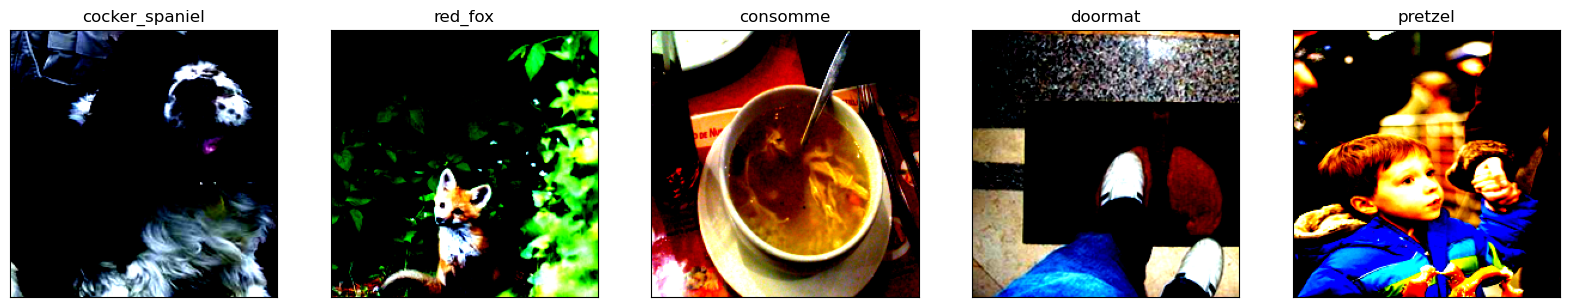

In [33]:
import random
import json

# 1000 classes
num_classes = 1000
with open('/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/imagenet_class_index.json') as f:
    class_index = json.load(f)
# Get the human-readable class names
class_names = [class_index[str(i)][1] for i in range(num_classes)]
# Print the class names
print(class_names)

writer = SummaryWriter('runs/paper_resnet34_lr1e-01')
# check random 5 examples of trainset
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(torch.randint(len(trainset), size=(5,))):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    image, label = trainset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_names[label])
    # record 5 examples of trainset to tensorboard
    writer.add_image(f"trainset_examples_{i}", image, label)
    

In [34]:
# training details
## randomly sample 224×224 crops for data augmentation.
## We use a mini-batch size of 256 images for fine-tuning
## The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
## We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
## We initialize the learning rate for the pre-trained network to be 0.01
model = models.resnet34(pretrained=False, progress=True)
print(model.eval)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# he initialization, not use bias
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.fill_(1)

model.apply(init_weights)

/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<bound method Module.eval of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# hyper parameters
## learning rate
lr = 0.1
## momentum
momentum = 0.9
## weight decay
L2 = 0.0001
# the number of iterations at 1 epoch
num_iters = (len(trainset) // mini_batch_size) + 1
# the number of epochs
epochs = 120
print(f"num_iters at 1 epoch: {num_iters}")
total_num_iters = num_iters * epochs
print(f"total num_iters: {total_num_iters}")

## optimizer
## scheduler
## loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=L2)        

## if val loss plateaus, lr decay
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.01)  # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

num_iters at 1 epoch: 5005
total num_iters: 600600


In [36]:
# record model to tensorboard
# Assuming 'device' is defined as torch.device("cuda") or "cuda:0"
input_tensor = trainset[0][0].unsqueeze(0).to(device)
writer.add_graph(model, input_tensor)

In [37]:
# for visualization, record training loss and val loss
train_loss_list = []
val_loss_list = []

# accuracy
val_acc_list = []

In [39]:
import time
# Start measuring time
start_time = time.time()

# ------------------------------------------------------------------------------------------------------------------------------

# training no pretrained resnet34 model with GPU
model.train().to(device)
for epoch in range(0, epochs):
    
    # if error plateaus, lr decay
            
    running_loss = 0.0
    print(f"{epoch+1} / {epochs} epoch ----------------------------------------")
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # every 1,000 iteration
        running_loss += loss.item()
        if i % 1000 == 999:
            print(f"[{epoch+1}, {i+1}th iteration] loss : {running_loss / 1000}")
            writer.add_scalar('training loss', running_loss / 1000, epoch * num_iters + i)
            running_loss = 0.0
            
    # every epoch
    # validation loss, accuracy
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    print(f"val loss : {val_loss / num_val_batch}")
    print(f"val acc : {100. * correct / total}")
    writer.add_scalar('validation loss', val_loss / num_val_batch, epoch)
    writer.add_scalar('validation acc', 100. * correct / total, epoch)
    writer.flush()
    lr_scheduler.step(val_loss / num_val_batch)
    val_loss_list.append(val_loss / num_val_batch)
    val_acc_list.append(100. * correct / total)
            
    
    # checkpoint
    PATH = f"./Paper_ResNet34_lr1e-01_Checkpoint/epoch_{epoch}.pth"
    torch.save(model.state_dict(), PATH)
    # save best model (minimum val loss)
    if val_loss / num_val_batch == min(val_loss_list):
        PATH = f"./Paper_ResNet34_lr1e-01_Checkpoint/best_model.pth"
        torch.save(model.state_dict(), PATH)
    
    
# ------------------------------------------------------------------------------- -----------------------------------------------        
        
# End measuring time
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

1 / 120 epoch ----------------------------------------
[1, 1000th iteration] loss : 6.361246560096741
[1, 2000th iteration] loss : 5.439419839859009
[1, 3000th iteration] loss : 4.86077321434021
[1, 4000th iteration] loss : 4.420394976377487
[1, 5000th iteration] loss : 4.084916980981827
val loss : 3.680910903580335
val acc : 23.644
2 / 120 epoch ----------------------------------------
[2, 1000th iteration] loss : 3.823293683052063
[2, 2000th iteration] loss : 3.6358520324230192
[2, 3000th iteration] loss : 3.4789773619174955
[2, 4000th iteration] loss : 3.3554471361637117
[2, 5000th iteration] loss : 3.257221994161606
val loss : 2.878339503492628
val acc : 36.774
3 / 120 epoch ----------------------------------------
[3, 1000th iteration] loss : 3.144292240858078
[3, 2000th iteration] loss : 3.0812744240760805
[3, 3000th iteration] loss : 3.0255794036388397
[3, 4000th iteration] loss : 2.9723961198329927
[3, 5000th iteration] loss : 2.934166440963745
val loss : 2.586973741346476
val 